In [1]:
import os
import cv2
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import matplotlib.pyplot as plt

In [2]:
def ssim(x, y, C1=0.01**2, C2=0.03**2, kernel_size=3):
    pad = kernel_size // 2
    mu_x = F.avg_pool2d(x, kernel_size, stride=1, padding=pad)
    mu_y = F.avg_pool2d(y, kernel_size, stride=1, padding=pad)

    mu_x2 = mu_x * mu_x
    mu_y2 = mu_y * mu_y
    mu_xy = mu_x * mu_y

    sigma_x2 = F.avg_pool2d(x * x, kernel_size, stride=1, padding=pad) - mu_x2
    sigma_y2 = F.avg_pool2d(y * y, kernel_size, stride=1, padding=pad) - mu_y2
    sigma_xy = F.avg_pool2d(x * y, kernel_size, stride=1, padding=pad) - mu_xy

    ssim_n = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
    ssim_d = (mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2)
    val_ssim = ssim_n / ssim_d

    # Clamp để tránh giá trị âm nhỏ do sai số máy tính, lấy mean
    return torch.clamp(val_ssim, 0, 1).mean()

In [3]:
class NYUDepth(Dataset):
    def __init__(self, root, split='train', resize=(256, 320)):
        self.resize = resize
        self.split = split
        
        if split == 'test':
            data_dir = os.path.join(root, 'test', 'official')
            
            from glob import glob
            rgb_paths = sorted(glob(os.path.join(data_dir, 'rgb_*.png')))
            depth_paths = sorted(glob(os.path.join(data_dir, 'depth_*.png')))
        else:
            from glob import glob
            rgb_paths = sorted(glob(os.path.join(root, 'train', '**', 'rgb_*.png'), recursive=True))
            depth_paths = sorted(glob(os.path.join(root, 'train', '**', 'depth_*.png'), recursive=True))

        # Ghép cặp
        self.pairs = []
        rgb_dict = {os.path.basename(p).split('_')[1].split('.')[0]: p for p in rgb_paths}
        depth_dict = {os.path.basename(p).split('_')[1].split('.')[0]: p for p in depth_paths}
        
        all_indices = sorted(set(rgb_dict.keys()) & set(depth_dict.keys()))
        for idx in all_indices:
            self.pairs.append({'rgb': rgb_dict[idx], 'depth': depth_dict[idx]})

        print(f"[{split.upper()}] Found {len(self.pairs)} pairs.")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        pair = self.pairs[i]
        
        img = cv2.imread(pair['rgb'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Đọc Depth (16-bit png -> mm)
        dep = cv2.imread(pair['depth'], cv2.IMREAD_UNCHANGED).astype(np.float32)

        # Resize
        if self.resize:
            img = cv2.resize(img, (self.resize[1], self.resize[0]), interpolation=cv2.INTER_LINEAR)
            dep = cv2.resize(dep, (self.resize[1], self.resize[0]), interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32) / 255.0
        img = np.moveaxis(img, -1, 0) # HWC -> CHW
        
        dep = dep / 1000.0 
        dep = np.expand_dims(dep, 0) # (1, H, W)

        return {'image': img, 'depth': dep}

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Module ASPP 
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size = x.shape[-2:]
        x = super(ASPPPooling, self).forward(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        # 1x1 Conv
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)))

        rates = atrous_rates
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) 
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

# Main Model: MobileNetV3 + DeepLab Head
class DeepLabV3PlusDepth(nn.Module):
    def __init__(self, max_depth=10.0):
        super(DeepLabV3PlusDepth, self).__init__()
        self.max_depth = max_depth
        
        # Backbone
        self.backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).features
        self.aspp = ASPP(in_channels=576, atrous_rates=[6, 12, 18], out_channels=256)
        
        # Decoder
        # 1. Xử lý Low-level features từ backbone
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(16, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        # Sau khi nối (ASPP upsample + Low level), input sẽ là 256 + 48 = 304
        self.final_conv = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, 1) # Output 1 channel depth
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        
        # --- Encoder ---
        low_level = self.backbone[0:2](x) # Output stride 4
        high_level = self.backbone[2:](low_level)
        x = self.aspp(high_level)
        
        # --- Decoder ---
        
        x = F.interpolate(x, size=low_level.shape[-2:], mode='bilinear', align_corners=False)
        low = self.low_level_conv(low_level)
        x = torch.cat([x, low], dim=1)
        x = self.final_conv(x)
        
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        
        return torch.sigmoid(x) * self.max_depth

In [5]:
def compute_loss(pred, gt):
    mask = (gt > 0.1) & (gt < 10.0)
    
    if mask.sum() == 0:
        return torch.tensor(0.0, requires_grad=True, device=pred.device), 0.0
        
    pred_valid = pred[mask]
    gt_valid = gt[mask]
    
    # L1 Loss (Absolute Error)
    l1 = torch.abs(pred_valid - gt_valid).mean()
    ssim_val = ssim(pred / 10.0, gt / 10.0)
    l_ssim = torch.clamp((1 - ssim_val) / 2, 0, 1)
    
    # Tổng hợp loss
    loss = 1.0 * l1 + 1.0 * l_ssim
    return loss, l1.item()

def compute_errors(pred, gt):
    """Tính các chỉ số đánh giá chuẩn cho bài Depth Estimation"""
    # Masking
    mask = (gt > 0.1) & (gt < 10.0)
    if mask.sum() == 0: return 0, 0, 0
    
    pred = pred[mask]
    gt = gt[mask]
    
    # RMSE
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    
    # Abs Relative Error
    rel = np.mean(np.abs(gt - pred) / gt)
    
    # Accuracy delta < 1.25
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    
    return rmse, rel, a1

[TRAIN] Found 621 pairs.
[TEST] Found 654 pairs.
Model sẵn sàng trên cuda. Bắt đầu train...
 [Check] GT Range: 0.00-65.53m | Pred Range: 0.81-8.61m
Epoch 1/50 | Time: 22.1s
  Train Loss: 1.6713 | Train L1: 1.3165 m
  Val RMSE: 2.3600 | Val Rel: 0.2435 | Acc(d<1.25): 0.3302
Epoch 2/50 | Time: 13.9s
  Train Loss: 0.9476 | Train L1: 0.6105 m
  Val RMSE: 1.5985 | Val Rel: 0.1716 | Acc(d<1.25): 0.5888
Epoch 3/50 | Time: 14.0s
  Train Loss: 0.8202 | Train L1: 0.4966 m
  Val RMSE: 1.4298 | Val Rel: 0.1601 | Acc(d<1.25): 0.6235
Epoch 4/50 | Time: 13.9s
  Train Loss: 0.7233 | Train L1: 0.4124 m
  Val RMSE: 1.4537 | Val Rel: 0.1638 | Acc(d<1.25): 0.6176
Epoch 5/50 | Time: 13.7s
  Train Loss: 0.7222 | Train L1: 0.4197 m
  Val RMSE: 1.4516 | Val Rel: 0.1645 | Acc(d<1.25): 0.6149
Epoch 6/50 | Time: 13.8s
  Train Loss: 0.7654 | Train L1: 0.4659 m
  Val RMSE: 1.3981 | Val Rel: 0.1569 | Acc(d<1.25): 0.6235
Epoch 7/50 | Time: 14.3s
  Train Loss: 0.6679 | Train L1: 0.3717 m
  Val RMSE: 1.4205 | Val Rel:

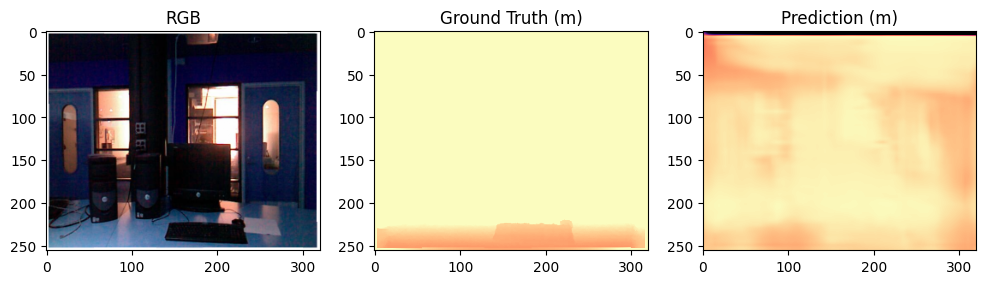

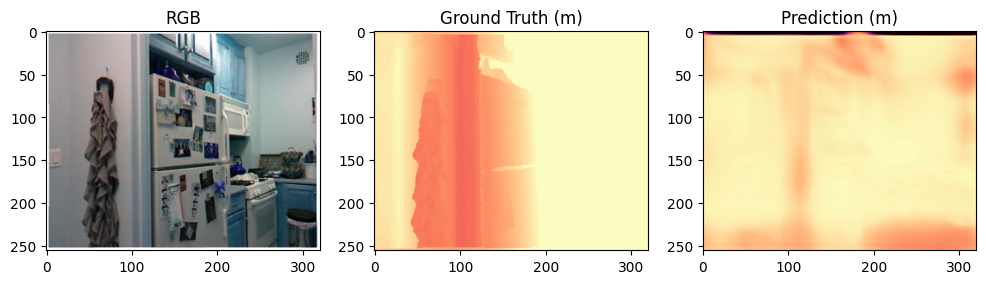

In [9]:
# --- Cấu hình ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 50

# Load Data
root_path = '/kaggle/input/nyuv2-official-split-dataset'
train_ds = NYUDepth(root_path, 'train')
val_ds = NYUDepth(root_path, 'test')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model & Optimizer
model = DeepLabV3PlusDepth(max_depth=10.0).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)

print(f"Model sẵn sàng trên {device}. Bắt đầu train...")

# --- Training Loop ---
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_l1 = 0
    start = time.time()
    
    for i, batch in enumerate(train_loader):
        img = batch['image'].to(device)
        dep = batch['depth'].to(device)
        
        optimizer.zero_grad()
        pred = model(img)
        
        loss, l1_val = compute_loss(pred, dep)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        train_l1 += l1_val
        
        # In thử batch đầu tiên để debug
        if i == 0 and epoch == 0:
            print(f" [Check] GT Range: {dep.min():.2f}-{dep.max():.2f}m | Pred Range: {pred.min().detach():.2f}-{pred.max().detach():.2f}m")

    # --- Validation Loop (Cuối mỗi epoch) ---
    model.eval()
    val_rmse, val_rel, val_a1 = [], [], []
    
    with torch.no_grad():
        for batch in val_loader:
            img = batch['image'].to(device)
            dep = batch['depth'].to(device)
            pred = model(img)
            
            # Chuyển về numpy để tính metrics
            pred_np = pred.cpu().numpy()
            dep_np = dep.cpu().numpy()
            
            for j in range(pred_np.shape[0]):
                r, re, a = compute_errors(pred_np[j], dep_np[j])
                val_rmse.append(r)
                val_rel.append(re)
                val_a1.append(a)
                
    # Tổng kết epoch
    print(f"Epoch {epoch+1}/{EPOCHS} | Time: {time.time()-start:.1f}s")
    print(f"  Train Loss: {train_loss/len(train_loader):.4f} | Train L1: {train_l1/len(train_loader):.4f} m")
    print(f"  Val RMSE: {np.mean(val_rmse):.4f} | Val Rel: {np.mean(val_rel):.4f} | Acc(d<1.25): {np.mean(val_a1):.4f}")

# --- Visualize Kết Quả ---
def show_result(dataset, model, idx=0):
    model.eval()
    data = dataset[idx]
    img_t = torch.from_numpy(data['image']).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t)
    
    img = data['image'].transpose(1, 2, 0)
    gt = data['depth'].squeeze()
    pred = pred.squeeze().cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("RGB")
    plt.subplot(1,3,2); plt.imshow(gt, cmap='magma', vmin=0, vmax=10); plt.title("Ground Truth (m)")
    plt.subplot(1,3,3); plt.imshow(pred, cmap='magma', vmin=0, vmax=10); plt.title(f"Prediction (m)")
    plt.show()

print("\n--- Kết quả dự đoán mẫu ---")
show_result(val_ds, model, idx=10)
show_result(val_ds, model, idx=50)